In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


2024-06-24 19:17:51.225641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-06-24 19:17:52.855822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 19:17:52.899538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 19:17:52.903972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Classical GAN

The goal of this notebook is to explore the possibility to use a GAN to generate jet images. The dataset used is the same as in the [Energy Energy Correlation](partonshower.ipynb) calculations, and will be used to generate a synthetic distribution of particle jets. The EEC calculation is then used to assess the quality of the physics model captured by this model.

## Table of Contents
1. [Data](##data)
2. [Model](##model)
3. [Training](##training)
4. [Results](##results)
5. [latent space](##exploring latent space)
6. [EEC](##energy-energy correlation functions)

## Data

The data used will be the synthetic quark and gluon data used in the previous example. Charged components only are used, and only the first 8 components with an energy at least 5 GeV are used with the remaining components discarded or padded with zeros.

### define some parameters of the problem

Here we define some parameters of the problem. Some parameters are only valid if running a conditional GAN. Others will be used shortly when loading the data.

In [3]:
epoch_num  = 50# total epoch to run
BATCH_SIZE = 1000 # batch size of train set
noise_dim  = 32   # dimension of noise vector for generator
gen_dim    = 4 # dimension of generator's output vector
num_hadron = 8
D_cycle    = 1 # train discriminator "D_cycle" times in one epoch
steps_plot = 1 # update figure per "steps_show" epochs

###### and load the data

In [4]:
e = np.loadtxt("/home/nondas/Documents/Pythia2Gan/PythiaMomenta.csv",delimiter=",")
e_split = np.split(e,len(e)/8)
events = np.stack(e_split)
print(events.shape)

(1000000, 8, 4)


(array([4.82000e+02, 1.36500e+03, 2.39400e+03, 3.26200e+03, 4.42500e+03,
        5.24000e+03, 6.46300e+03, 7.28400e+03, 8.32300e+03, 9.35400e+03,
        1.03830e+04, 1.13360e+04, 1.23220e+04, 1.34600e+04, 1.47570e+04,
        1.58380e+04, 1.73570e+04, 1.87950e+04, 2.04660e+04, 2.23910e+04,
        2.39400e+04, 2.65750e+04, 2.91470e+04, 3.21700e+04, 3.56890e+04,
        3.90930e+04, 4.35430e+04, 4.79910e+04, 5.38260e+04, 5.96960e+04,
        6.59140e+04, 7.30780e+04, 8.00160e+04, 8.76490e+04, 9.64420e+04,
        1.05391e+05, 1.14355e+05, 1.23434e+05, 1.33457e+05, 1.43476e+05,
        1.55364e+05, 1.66818e+05, 1.79580e+05, 1.94301e+05, 2.10011e+05,
        2.28086e+05, 2.44658e+05, 4.58642e+05, 3.02084e+05, 3.92424e+05,
        2.75833e+05, 2.62569e+05, 2.47227e+05, 3.03177e+05, 2.20248e+05,
        2.04174e+05, 1.89899e+05, 1.76275e+05, 1.63689e+05, 1.53365e+05,
        1.43426e+05, 1.33243e+05, 1.23945e+05, 1.14023e+05, 1.06068e+05,
        9.77040e+04, 9.00460e+04, 8.19840e+04, 7.46

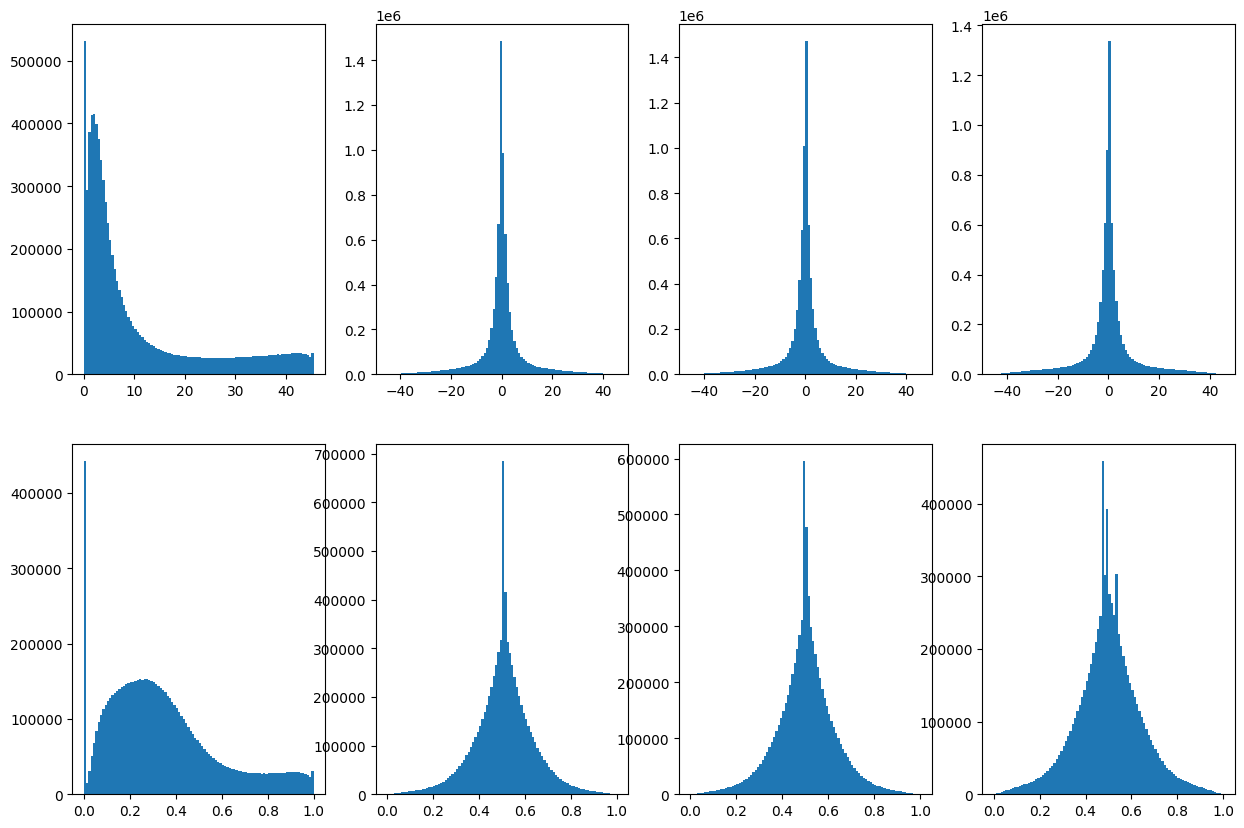

In [5]:
# explore to limits

fig,(ax1,ax2) = plt.subplots(2,4,figsize=(15,10))
ax1[0].hist(events[:,:,0].flatten(),bins=100)
ax1[1].hist(events[:,:,1].flatten(),bins=100)
ax1[2].hist(events[:,:,2].flatten(),bins=100)
ax1[3].hist(events[:,:,3].flatten(),bins=100)
# normalise all 8 x 3 features with MinMaxScaler

scalers = np.zeros((num_hadron,gen_dim),dtype=object)
for i in range(num_hadron):
    for j in range(gen_dim):
        scalers[i,j] = MinMaxScaler().fit(events[:,i,j].reshape(-1,1))
        events[:,i,j] = scalers[i,j].transform(events[:,i,j].reshape(-1,1)).flatten()

ax2[0].hist(events[:,:,0].flatten(),bins=100)
ax2[1].hist(events[:,:,1].flatten(),bins=100)
ax2[2].hist(events[:,:,2].flatten(),bins=100)
ax2[3].hist(events[:,:,3].flatten(),bins=100)



make training and test sets

In [6]:
x_train, x_valid = train_test_split(np.array(events), test_size=0.1)

# load into tensorflow dataset dtype as float32
pythia_dataset = tf.data.Dataset.from_tensor_slices(x_train.astype(np.float32))
pythia_dataset = pythia_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)



print(f"Shape of training images: {x_train.shape}")

Shape of training images: (900000, 8, 4)


2024-06-24 19:18:01.962782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 19:18:01.966300: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-24 19:18:01.968835: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Model

Here we define our standard GAN architecture with only 4 fully connected layers

In [7]:
def Generator():
    model = tf.keras.Sequential()
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(128, activation='leaky_relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(64, activation='leaky_relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(32, activation='leaky_relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(gen_dim*num_hadron, activation='sigmoid'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Reshape((num_hadron,gen_dim)))
    return model

def Discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(num_hadron,gen_dim)))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model


In [8]:
generator = Generator()
discriminator = Discriminator()

print(generator.summary())
print(discriminator.summary())

/home/nondas/miniconda3/envs/Jup/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

None


### Loss definitions and training operations

In [9]:
lambda_reg = 0.0
Minkowski = tf.constant([1.0,-1.0,-1.0,-1.0])

        


def discriminator_loss(D_real, D_fake, penalty):
    D_loss = tf.reduce_mean(D_fake - D_real) #+ lambda_reg * penalty)
    return D_loss

def generator_loss(D_fake,X_real,G_fake):
    ######## Constructing the rank-2 tensors of the on-shell condition
    L1 = tf.reduce_mean(tf.math.abs(tf.reduce_sum(X_real*X_real*Minkowski,axis=-1) - tf.reduce_sum(G_fake*G_fake*Minkowski,axis=-1)))
    #L2 = tf.reduce_mean(tf.math.square(tf.reduce_sum(X_real*X_real*Minkowski,axis=-1) - tf.reduce_sum(G_fake*G_fake*Minkowski,axis=-1)))

    # Perform min-max scaling per row
    
    lambda_on = 0.1
    Original_Loss  = - tf.reduce_mean(D_fake)
    G_loss =  Original_Loss + lambda_on*L1
    return G_loss,Original_Loss,L1

## Generator optimizer and Discriminator optimizer

generator_optimizer = tf.keras.optimizers.Adam(1e-5,beta_1=0.5,beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.5, beta_2=0.9)



        #to the Discriminator loss ##
def penalty_calculation(X_real, G_fake):
    epsilon = tf.random.uniform(shape=tf.shape(X_real), minval=0, maxval=1.)
    interpolation = epsilon * X_real + (1 - epsilon) * G_fake

    with tf.GradientTape() as pena_tape:
        pena_tape.watch(interpolation)
        norm = tf.norm(pena_tape.gradient(discriminator(interpolation), interpolation),axis=1)
        #if abs(tf.reduce_mean(norm) -3.) > 1:
            #tf.print("norm",tf.reduce_mean(norm))
        penalty = (norm - 1) ** 2.0
    return penalty



## Training

In [10]:
## Train Generator and Discriminator independently  ##
@tf.function
def train_G(data_batch,ep):
    noise = tf.random.normal(
            [data_batch.shape[0], noise_dim], 
            mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
    )
    with tf.GradientTape() as gen_tape:
        
        G_fake = generator(noise, training=True)        
        D_fake = discriminator(G_fake, training=True)
        G_loss,Original_Loss,L1 = generator_loss(D_fake,data_batch,G_fake)
        
    gradients_of_generator = gen_tape.gradient(G_loss, generator.trainable_variables)
    clipped_gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_generator]
    generator_optimizer.apply_gradients(zip(clipped_gradients, generator.trainable_variables))
    return G_loss,Original_Loss,L1

In [11]:
@tf.function
def train_D(data_batch):
    noise = tf.random.normal(
            [data_batch.shape[0], noise_dim], 
            mean=0.0, stddev=1.0, dtype=tf.dtypes.float32
    )
    with tf.GradientTape() as disc_tape:
        G_fake = generator(noise, training=True)
        D_real = discriminator(data_batch, training=True)
        D_fake = discriminator(G_fake, training=True)
        penalty = penalty_calculation(data_batch, G_fake)
        D_loss = discriminator_loss(D_real, D_fake, penalty)
    gradients_of_discriminator = disc_tape.gradient(D_loss, discriminator.trainable_variables)
    clipped_gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients_of_discriminator]    
    discriminator_optimizer.apply_gradients(zip(clipped_gradients, discriminator.trainable_variables))
    return D_loss

And now we train the model!

In [12]:
def train(dataset, epochs):
    D_loss_list = []
    G_loss_list = []
    Original_Loss_list = []
    L1_list = []
    for epoch in range(epochs):
        for data_batch in dataset:
            for i in range(D_cycle):
                D_loss = train_D(data_batch)
            G_loss,Original_Loss,L1 = train_G(data_batch,epoch)
        D_loss_list.append(D_loss)
        G_loss_list.append(G_loss)
        Original_Loss_list.append(Original_Loss)
        L1_list.append(L1)
        if epoch % steps_plot == 0:
            # plot the jet output from the generator
            #noise = tf.random.normal([1, noise_dim], mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
            #G_fake = generator(noise, training=False)
            # plot a histogram of the jet image
            #plt.figure(figsize=(5,5))
            #plt.imshow(G_fake[0])
            
            print(f"Epoch {epoch+1} D_loss={D_loss:.4f} G_loss={G_loss:.4f} L1 = {L1:.4f}")
    return D_loss_list, G_loss_list,Original_Loss_list,L1_list

In [13]:
D_loss_list, G_loss_list,Original_Loss_list,L1_list = train(pythia_dataset, epoch_num)

2024-06-24 19:18:07.704808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1 D_loss=-0.0833 G_loss=-0.4013 L1 = 0.2774


2024-06-24 19:18:11.170213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 D_loss=-0.1515 G_loss=-0.3802 L1 = 0.2681


2024-06-24 19:18:14.655107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 D_loss=-0.1734 G_loss=-0.3604 L1 = 0.2513


2024-06-24 19:18:17.867173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 D_loss=-0.0666 G_loss=-0.3589 L1 = 0.2544


2024-06-24 19:18:20.930587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 D_loss=-0.0194 G_loss=-0.3386 L1 = 0.2787


2024-06-24 19:18:23.970820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 6 D_loss=-0.0641 G_loss=-0.3478 L1 = 0.3246


2024-06-24 19:18:26.992086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7 D_loss=-0.0780 G_loss=-0.3772 L1 = 0.3002


2024-06-24 19:18:30.012964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 D_loss=-0.0464 G_loss=-0.4297 L1 = 0.3036


2024-06-24 19:18:33.087816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 D_loss=-0.0849 G_loss=-0.4443 L1 = 0.3225


2024-06-24 19:18:36.135794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10 D_loss=-0.1346 G_loss=-0.4115 L1 = 0.3004


2024-06-24 19:18:39.180369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 11 D_loss=-0.1373 G_loss=-0.3912 L1 = 0.2999


2024-06-24 19:18:42.272345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 12 D_loss=-0.1440 G_loss=-0.3827 L1 = 0.2806


2024-06-24 19:18:45.305947: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 13 D_loss=-0.1742 G_loss=-0.3709 L1 = 0.2722


2024-06-24 19:18:48.334247: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 14 D_loss=-0.1293 G_loss=-0.3782 L1 = 0.2630


2024-06-24 19:18:51.359824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 15 D_loss=-0.1534 G_loss=-0.3488 L1 = 0.2717


2024-06-24 19:18:54.421456: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16 D_loss=-0.1948 G_loss=-0.3427 L1 = 0.2874


2024-06-24 19:18:57.448269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17 D_loss=-0.1979 G_loss=-0.3375 L1 = 0.2812


2024-06-24 19:19:00.500860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 18 D_loss=-0.2007 G_loss=-0.3355 L1 = 0.2746


2024-06-24 19:19:03.518772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 19 D_loss=-0.2154 G_loss=-0.3103 L1 = 0.2864


2024-06-24 19:19:06.547713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20 D_loss=-0.1801 G_loss=-0.2860 L1 = 0.2917


2024-06-24 19:19:09.573476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 21 D_loss=-0.1382 G_loss=-0.2716 L1 = 0.2829


2024-06-24 19:19:12.598295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 22 D_loss=-0.1255 G_loss=-0.2609 L1 = 0.2661


2024-06-24 19:19:15.624008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 23 D_loss=-0.0991 G_loss=-0.3017 L1 = 0.2628


2024-06-24 19:19:18.680842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 24 D_loss=-0.0460 G_loss=-0.2408 L1 = 0.2795


2024-06-24 19:19:21.739680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 25 D_loss=-0.0439 G_loss=-0.3581 L1 = 0.2926


2024-06-24 19:19:24.785373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 26 D_loss=-0.0302 G_loss=-0.3805 L1 = 0.2988


2024-06-24 19:19:27.811256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 27 D_loss=-0.0414 G_loss=-0.4696 L1 = 0.2780


2024-06-24 19:19:30.780903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 28 D_loss=-0.0299 G_loss=-0.4244 L1 = 0.2633


2024-06-24 19:19:33.733363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 29 D_loss=-0.0304 G_loss=-0.4304 L1 = 0.2669


2024-06-24 19:19:36.863481: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 30 D_loss=-0.0222 G_loss=-0.4189 L1 = 0.2719


2024-06-24 19:19:39.811135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 31 D_loss=-0.0209 G_loss=-0.4504 L1 = 0.2562


2024-06-24 19:19:42.767837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32 D_loss=-0.0266 G_loss=-0.4453 L1 = 0.2651


2024-06-24 19:19:45.718468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33 D_loss=-0.0277 G_loss=-0.4531 L1 = 0.2549


2024-06-24 19:19:48.681094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 34 D_loss=-0.0270 G_loss=-0.4350 L1 = 0.2557


2024-06-24 19:19:51.628688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 35 D_loss=-0.0265 G_loss=-0.4313 L1 = 0.2553


2024-06-24 19:19:54.572400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 36 D_loss=-0.0317 G_loss=-0.4285 L1 = 0.2634


2024-06-24 19:19:57.529735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 37 D_loss=-0.0368 G_loss=-0.4429 L1 = 0.2546


2024-06-24 19:20:00.513744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 38 D_loss=-0.0400 G_loss=-0.4297 L1 = 0.2504


2024-06-24 19:20:03.466421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 39 D_loss=-0.0427 G_loss=-0.4355 L1 = 0.2567


2024-06-24 19:20:06.436153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40 D_loss=-0.0304 G_loss=-0.4239 L1 = 0.2511


2024-06-24 19:20:09.409786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 41 D_loss=-0.0469 G_loss=-0.4273 L1 = 0.2499


2024-06-24 19:20:12.361395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 42 D_loss=-0.0419 G_loss=-0.4328 L1 = 0.2423


2024-06-24 19:20:15.310088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 43 D_loss=-0.0338 G_loss=-0.4479 L1 = 0.2536


2024-06-24 19:20:18.280741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 44 D_loss=-0.0295 G_loss=-0.4369 L1 = 0.2550


2024-06-24 19:20:21.236365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 45 D_loss=-0.0259 G_loss=-0.4522 L1 = 0.2500


2024-06-24 19:20:24.176996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 46 D_loss=-0.0385 G_loss=-0.4449 L1 = 0.2512


2024-06-24 19:20:27.119655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 47 D_loss=-0.0417 G_loss=-0.4285 L1 = 0.2595


2024-06-24 19:20:30.070120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 48 D_loss=-0.0355 G_loss=-0.4333 L1 = 0.2531


2024-06-24 19:20:33.113190: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 49 D_loss=-0.0378 G_loss=-0.4425 L1 = 0.2442
Epoch 50 D_loss=-0.0389 G_loss=-0.4344 L1 = 0.2538


2024-06-24 19:20:36.200420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


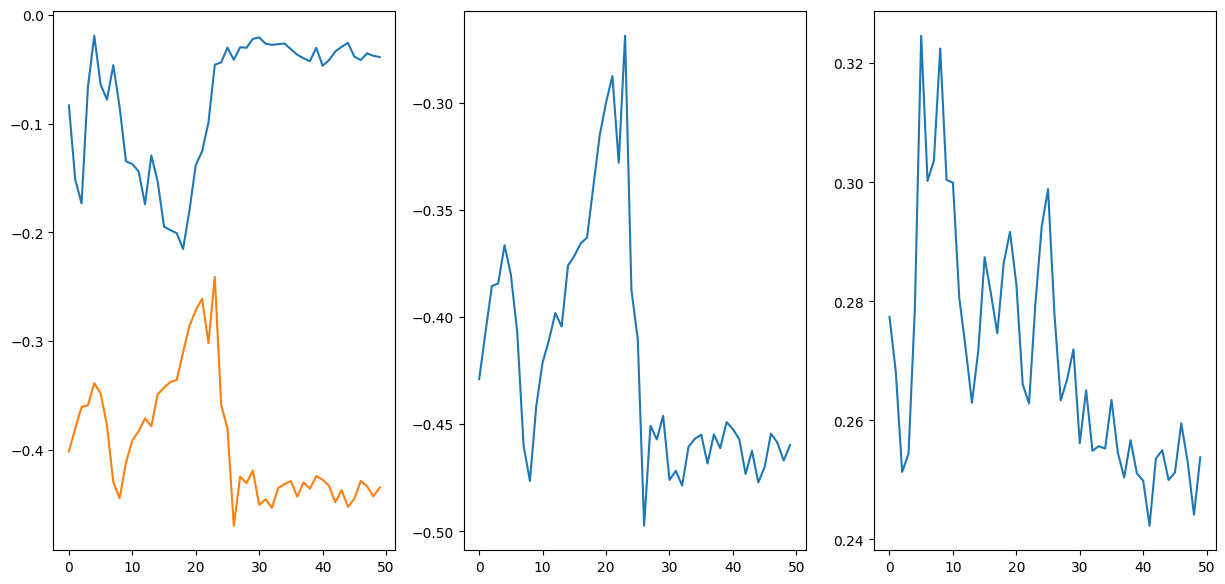

In [14]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
ax[0].plot(range(epoch_num),D_loss_list)
ax[0].plot(range(epoch_num),G_loss_list)
ax[1].plot(range(epoch_num),Original_Loss_list)
ax[2].plot(range(epoch_num),L1_list)


Save weights for later

In [15]:
generator.save_weights('./training_checkpoints/OnShellGan.weights.h5')

In [16]:
generator.load_weights('./training_checkpoints/OnShellGan.weights.h5')

In [17]:
noise = tf.random.normal([len(events),noise_dim],mean=0,stddev=1.)

In [18]:
generated_jets = generator(noise)

In [19]:
#rescale to original values
generated_jets = generated_jets.numpy()
gan_events_scaled = np.copy(generated_jets[0:10000,:,:])
events_scaled = np.copy(events[0:10000,:,:])
for i in range(num_hadron):
    for j in range(gen_dim):
        generated_jets[:,i,j] = scalers[i,j].inverse_transform(generated_jets[:,i,j].reshape(-1,1)).flatten()
        events[:,i,j] = scalers[i,j].inverse_transform(events[:,i,j].reshape(-1,1)).flatten()
     

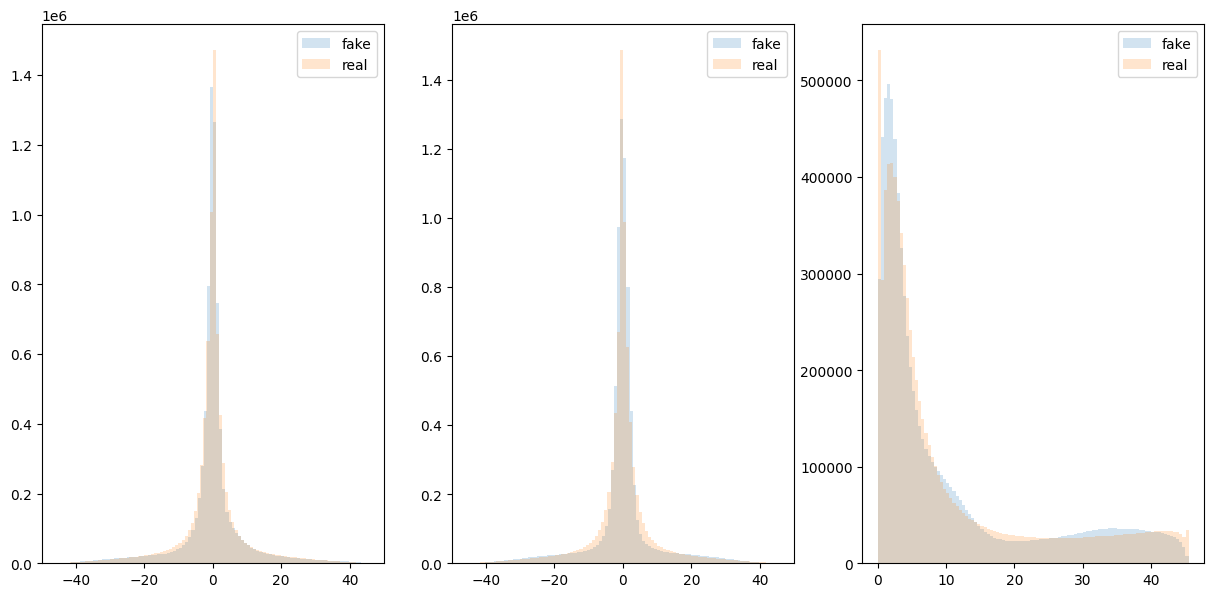

In [20]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
ax[0].hist(generated_jets[:,:,2].flatten(),bins=100,alpha=.2,label="fake")
ax[0].hist(events[:,:,2].flatten(),bins=100, alpha=.2, label="real")
ax[0].legend()
ax[1].hist(generated_jets[:,:,1].flatten(),bins=100,alpha=.2,label="fake")
ax[1].hist(events[:,:,1].flatten(),bins=100, alpha=.2, label="real")
ax[1].legend()
ax[2].hist(generated_jets[:,:,0].flatten(),bins=100,alpha=.2,label="fake")
ax[2].hist(events[:,:,0].flatten(),bins=100, alpha=.2, label="real")
ax[2].legend();

## Full Range EEC

In [28]:
gan_events_unscaled = generated_jets[0:10000,:,:]
events_unscaled = events[0:10000,:,:]
print(gan_events_unscaled.shape)
print(events_unscaled.shape)
gan_final = gan_events_unscaled.reshape(-1,gan_events.shape[-1])
np.savetxt("PythiaGan.csv",gan_final, delimiter=",") 

(10000, 8, 4)
(10000, 8, 4)


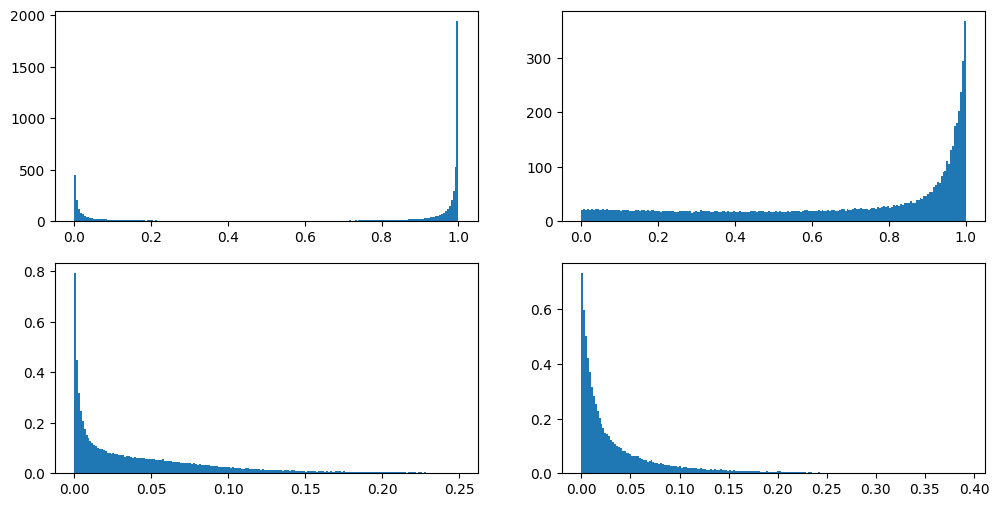

In [40]:
ECM = 91.0

def dot(q1,q2):
    y = q1[1]*q2[1]+q1[2]*q2[2]+q1[3]*q2[3]
    return y

def z_angle(p1,p2):
    if dot(p1,p1)==0.0 or dot(p2,p2) == 0:
        cos_phi = 1.0
    else:
        cos_phi = dot(p1,p2)/(np.sqrt(dot(p1,p1))*np.sqrt(dot(p2,p2)))
    z = (1.0-cos_phi)/2.0    
    return z
    





def EEC(lst):
    EEC_list = []
    for i in range(lst.shape[0]):
        for j in range(lst.shape[1]):
            for k in range(lst.shape[1]):
                if j!=k:
                    z = z_angle(lst[i,j],lst[i,k])
                    w = lst[i,j,0]*lst[i,k,0]/((ECM**2.0))
                    EEC_list.append((z,w))
    return EEC_list

Real_EEC = EEC(events_unscaled)
real_angles = [item[0] for item in Real_EEC]
real_weights = [item[1] for item in Real_EEC]

Gen_EEC = EEC(gan_events_unscaled)
gen_angles = [item[0] for item in Gen_EEC]
gen_weights = [item[1] for item in Gen_EEC]

Scaled_Real_EEC = EEC(events_scaled)
scaled_real_angles = [item[0] for item in Scaled_Real_EEC]
scaled_real_weights = [item[1] for item in Scaled_Real_EEC]

Scaled_Gen_EEC = EEC(gan_events_scaled)
scaled_gen_angles = [item[0] for item in Scaled_Gen_EEC]
scaled_gen_weights = [item[1] for item in Scaled_Gen_EEC]


    
                        
             




fig,(ax1,ax2) = plt.subplots(2,2,figsize=(12,6))


ax1[0].hist(real_angles,bins=200,weights = real_weights)
ax1[1].hist(gen_angles,bins=200,weights = gen_weights)
ax2[0].hist(scaled_real_angles,bins=200,weights = scaled_real_weights)
ax2[1].hist(scaled_gen_angles,bins=200,weights = scaled_gen_weights)
plt.show()

## Invariant Mass Squared

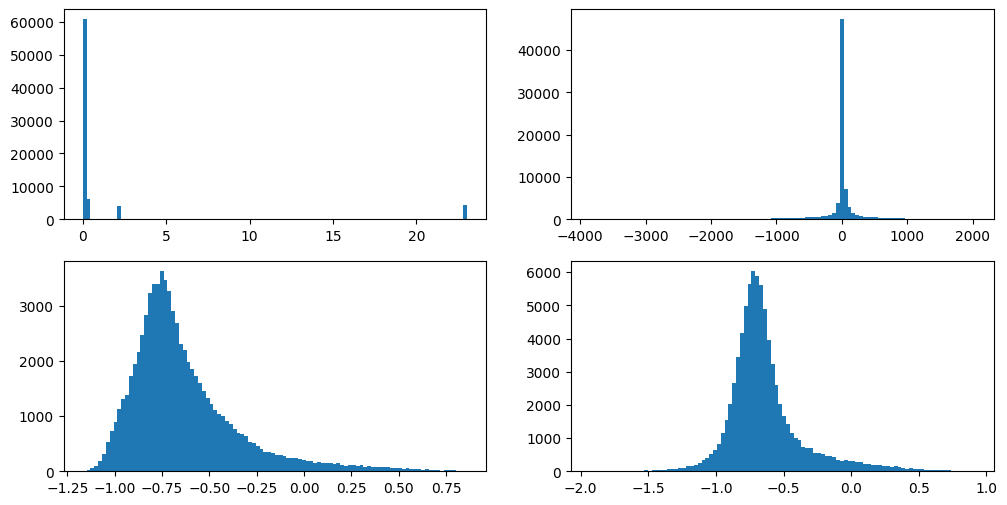

In [39]:
def m2(h):
    m2 = []
    for event in h:
        for particle in event:
            if particle[0]!=0.0 and particle[1]!=0.0 and particle[2]!=0.0 and particle[3]!=0.0:
                mass2 = particle[0]**2 - (particle[1]**2 + particle[2]**2 + particle[3]**2)
                m2.append(mass2)

    return m2

masses_real = m2(events_unscaled)
masses_gen = m2(gan_events_unscaled) 
scaled_masses_real = m2(events_scaled)
scaled_masses_gen = m2(gan_events_scaled)

fig,(ax1,ax2) = plt.subplots(2,2,figsize=(12,6))


ax1[0].hist(masses_real,bins=100)
ax1[1].hist(masses_gen,bins=100)
ax2[0].hist(scaled_masses_real,bins=100)
ax2[1].hist(scaled_masses_gen,bins=100)
plt.show()


            